In [ ]:
#| default_exp proteomics

# 🔬 Proteomics Quality Control: Beyond the Basics

> ##  Peptide Identification Rate Analysis

Identification rates across retention time tell a powerful story about your chromatography and instrument performanc.
By visualizing these patterns, we can:

- **Pinpoint** chromatographic issues before they compromise your analysis
- **Track** instrument performance over time
- **Validate** analytical methods with quantitative metrics

### ⚠️ Critical Note for DIA-NN Users

When working with DIA-NN output, setting the **precursor FDR threshold to 100%** is essential for meaningful quality control. This approach ensures:

- **Complete tracking** of both identified and non-identified precursors
- **Comprehensive coverage** of all MS2 events across the chromatographic gradient
- **Unbiased assessment** of identification success rates in different RT regions
- **Detection of pattern anomalies** that might be missed with stringent filtering


In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
#pl.read_csv??

In [ ]:
'''
path ='/Volumes/dgh-lab/PROTEOMICS_DATA_DUMP/020_2025_DUN_DH/DIA-NN/020_2025_DUN_DH/'
fname = '020_2025_DUN_DH-report.parquet'
tmp = pl.read_parquet(os.path.join(path,fname)).to_pandas()
tmp['RT.Diff']=tmp['RT.Stop']-tmp['RT.Start']
tmp['RT.Bin']=tmp['RT'].astype(int)
rt_dataset = tmp[['Run','RT','RT.Start','RT.Stop','RT.Diff','RT.Bin','Q.Value','Ms1.Area','Precursor.Quantity']]
rt_dataset = rt_dataset.sort_values(['Run','RT'])
rt_dataset['Significant']=(rt_dataset['Q.Value']<0.01).astype(int)
rt_dataset.head()
rt_dataset['Significant'].value_counts()
rt_dataset[rt_dataset['Run']=='020_2025-DUN_DH-GB-2T1-A'].plot(kind='scatter',x='RT',y='RT.Diff')
# evantually track
RT vs Precursor.Quantity / Ms1.Area
RT vs RT.Diff
'''
print(1)
# working in progress

1


In [ ]:
#| export
def prepare_data_MaxQuant(df):
    pass

In [ ]:
#| export
def prepare_data_Spectronaut(df):
    pass

In [ ]:
#| export
def prepare_data_DiaNN(df):
    """
    Process DIA-NN output data to prepare it for plotting retention time bin analysis.
    
    This function takes DIA-NN report output and:
    1. Creates retention time bins from the RT column
    2. Groups data by Run and RT bin
    3. Counts identified and non-identified peptides in each bin
    4. Calculates the identification ratio
    
    Parameters:
    -----------
    df : polars.DataFrame
        DIA-NN output containing at minimum the columns:
        - 'Run': The run/sample identifier
        - 'RT': Retention time values (in minutes)
        - 'PG.Q.Value': Protein group Q-value (false discovery rate)
        - 'Q.Value': Peptide Q-value (false discovery rate)
    
    Returns:
    --------
    polars.DataFrame
        A processed DataFrame with the following columns:
        - 'Run': The run/sample identifier
        - 'RT_bin': Binned retention time (integer)
        - 'Identified': Count of peptides with both PG.Q.Value and Q.Value ≤ 0.01
        - 'NotIdentified': Count of peptides that don't meet the Q-value thresholds
        - 'ratio': Proportion of identified peptides (Identified/(Identified+NotIdentified))
        
    Notes:
    ------
    - The function uses a 1% FDR threshold for peptide identifications
    - RT values are binned by truncating to integers (e.g., 10.7 → 10)
    - The resulting DataFrame is sorted by Run and then RT_bin
    """
    # Create RT bins by casting RT values to integers
    # This effectively truncates decimal values (e.g., 10.7 becomes 10)
    df = df.with_columns([
        pl.col("RT").cast(int).alias("RT_bin")
    ])
    
    # Group by "Run" and "RT_bin" and calculate metrics
    results = (df
               .group_by(["Run", "RT_bin"])
               .agg([
                   # Count identified peptides - those passing the 1% FDR threshold
                   # at both protein group and peptide levels
                   pl.when( (pl.col("Q.Value") <= 0.01))
                    .then(1)  # If condition is met, count as 1
                    .otherwise(0)  # If condition is not met, count as 0
                    .sum()  # Sum all the 1s to get total count
                    .alias("Identified"),
                   
                   # Count non-identified peptides - those failing either FDR threshold
                   pl.when((pl.col("Q.Value") <= 0.01))
                    .then(0)  # If condition is met (identified), count as 0
                    .otherwise(1)  # If condition is not met (not identified), count as 1
                    .sum()  # Sum all the 1s to get total count
                    .alias("NotIdentified")
               ])
              )
    
    # Calculate the identification ratio (proportion of peptides that were identified)
    results = results.with_columns(
        (pl.col("Identified") / (pl.col("NotIdentified") + pl.col("Identified"))).alias("ratio")
    )
    
    # Sort the results DataFrame by "Run" and "RT_bin" for easier analysis
    results = results.sort(["Run", "RT_bin"])
    
    return results


In [ ]:
#| export
def plot_proteomics_run(df, run_name=None, figsize=(12, 6), identified_color='blue', notidentified_color='red', 
                        alpha=1.0, add_labels=True, use_different_colors=False):
    """
    Plot RT_bin vs Identified and RT_bin vs NotIdentified for runs.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing Run, RT_bin, Identified, and NotIdentified columns
    run_name : str, optional (default=None)
        Name of the run to plot. If None, plots all runs overlapping.
    figsize : tuple, optional (default=(12, 6))
        Figure size as (width, height) in inches
    identified_color : str, optional (default='blue')
        Color for the Identified line
    notidentified_color : str, optional (default='red')
        Color for the NotIdentified line
    alpha : float, optional (default=1.0)
        Transparency for the lines
    add_labels : bool, optional (default=True)
        Whether to add data labels for NotIdentified points
    use_different_colors : bool, optional (default=False)
        If True and plotting all runs, use different colors for each run
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine which runs to plot
    if run_name is not None:
        runs_to_plot = [run_name]
        title = f'Identified vs NotIdentified Precursors by Retention Time: {run_name}'
    else:
        runs_to_plot = df['Run'].unique()
        title = 'Identified vs NotIdentified Precursors by Retention Time'
    
    # Set up color palettes if using different colors
    n_runs = len(runs_to_plot)
    if use_different_colors and run_name is None:
        identified_colors = plt.cm.viridis(np.linspace(0, 0.8, n_runs))
        notidentified_colors = plt.cm.plasma(np.linspace(0, 0.8, n_runs))
    
    # Loop through each run to plot
    for i, run in enumerate(runs_to_plot):
        run_data = df[df['Run'] == run].copy()
        
        if run_data.empty:
            print(f"No data found for run '{run}'")
            continue
        
        # Determine colors for this run
        if use_different_colors and run_name is None:
            i_color = identified_colors[i]
            ni_color = notidentified_colors[i]
            run_label = run  # Use run name as label when using different colors
        else:
            i_color = identified_color
            ni_color = notidentified_color
            # Only add to legend for first run when all runs use same colors
            run_label = run if i == 0 or use_different_colors else None
        
        # Plot Identified
        ax.plot(run_data['RT_bin'], run_data['Identified'], 
                marker='o', linestyle='-', color=i_color, alpha=alpha,
                label=f'{run} - Identified' if use_different_colors else ('Identified' if i == 0 else None))
        
        # Plot NotIdentified on the same axis
        ax.plot(run_data['RT_bin'], run_data['NotIdentified'], 
                marker='s', linestyle='-', color=ni_color, alpha=alpha,
                label=f'{run} - NotIdentified' if use_different_colors else ('NotIdentified' if i == 0 else None))
        
        # Add data labels for NotIdentified points where count > 0
        #if add_labels and (run_name is not None or n_runs <= 3):  # Only add labels for single run or small number of runs
        #    for _, row in run_data.iterrows():
        #        if row['NotIdentified'] > 0:
        #            ax.annotate(f"{int(row['NotIdentified'])}", 
        #                      (row['RT_bin'], row['NotIdentified']),
        #                      xytext=(5, 5), textcoords='offset points')
    
    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel('RT_bin')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

## Example
```python
path ='/Volumes/dgh-lab/PROTEOMICS_DATA_DUMP/020_2025_DUN_DH/DIA-NN/020_2025_DUN_DH/'
fname = '020_2025_DUN_DH-report.parquet'
tmp = pl.read_parquet(os.path.join(path,fname))
count_data= prepare_data_DiaNN(tmp)
count_data=count_data.to_pandas()
count_data.head()
plot_proteomics_run(count_data)
```

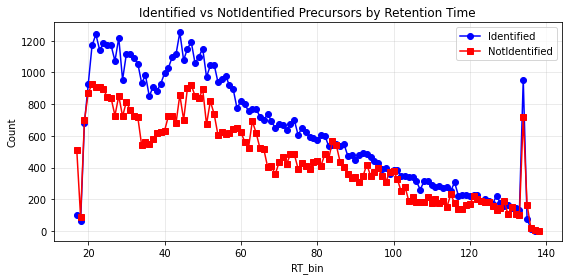

In [ ]:
#| hide
fname = '../tests/proteomics/dia_nn_report.tsv.gz'
tmp = pl.read_csv(fname,separator='\t')
count_data= prepare_data_DiaNN(tmp)
count_data=count_data.to_pandas()
_ = plot_proteomics_run(count_data,
                               figsize=(8,4))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()